# Plot tree trajectories in simple 2D spaces

Trying to identify a space where tree evolution is clear, and types of trees are clear. The spaces should be meaningful.

## 1 Setup

Setup the database

In [1]:
from utils import setup_spreadr
setup_spreadr('spreadr_exp_1')

Imports for the analysis

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from pandas import DataFrame
import seaborn as sb

from gists.models import Sentence, Tree

from utils import grouper, memoized, mpl_palette

Equip models with useful tools

In [3]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

## 2 Exploration

### 2.1 Number of content words ~ distance to root

First build our data

In [116]:
trees = Tree.objects.experiment.all()
data = []
order = []
for tree in trees:
    root = tree.root
    order.append({'tree id': tree.id,
                  'root_content_words_count': len(root.content_words)})
    for sentence in tree.sentences.ham.all():
        data.append({'tree id': tree.id,
                     'sentence id': sentence.id,
                     'length': len(sentence.content_words),
                     'distance to root': \
                         root.ordered_content_distance(sentence, normalized=False) / \
                         len(root.content_words)
                    })
data = DataFrame(data)
root_order = DataFrame(order).sort_values(by='root_content_words_count')

**First look from afar** (all plots are **ordered by number of content words in the root of the tree**)

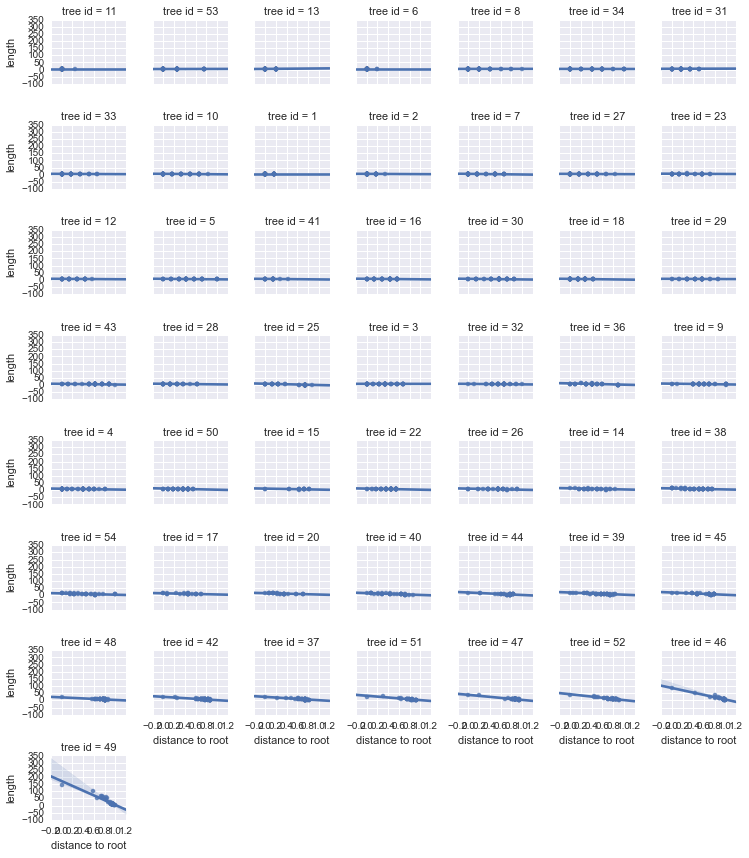

In [112]:
sb.lmplot(data=data.sort_values(by='length'),
          y='length', x='distance to root',
          col='tree id', col_wrap=7, size=1.5,
          col_order=root_order['tree id']);

We can remove trees #46 and #49 which are of another category (they are very long multi-paragraph pieces of text).

**Second look**

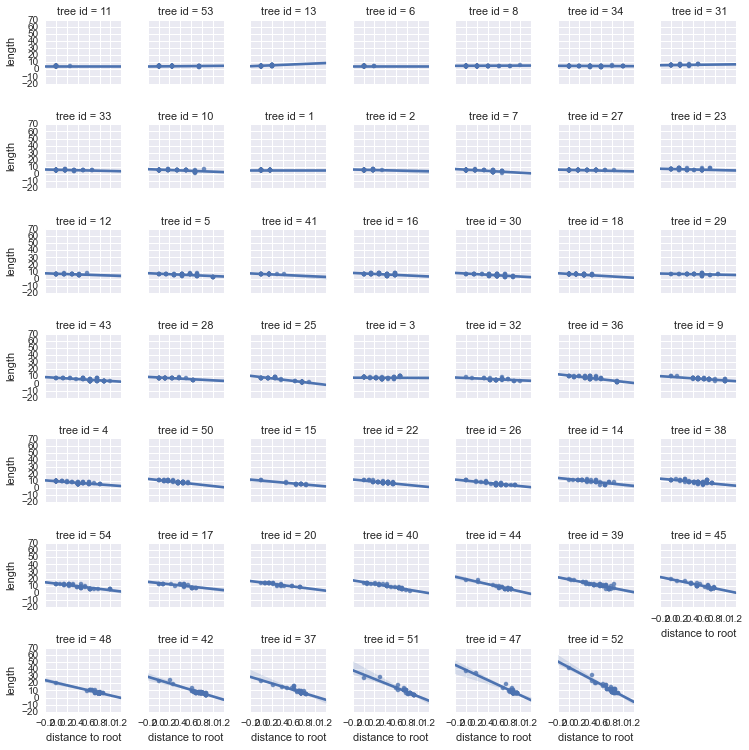

In [113]:
sb.lmplot(data=data[~data['tree id'].isin([46, 49])],
          y='length', x='distance to root',
          col='tree id', col_wrap=7, size=1.5,
          col_order=root_order[~root_order['tree id'].isin([46, 49])]['tree id']);

Most trees seem to have fairly aligned data points, with flat or negative slope (i.e. the shorter the sentence, the more different it is from its root).

Except #13 (we'll see later its 42 data points are concentrated in only 3 different locations so there's more to that).

We can further remove #37, #39, #42, #44, #45, #47, #48, #51, and #52, which have 15 or more content words:

In [84]:
threshold = 15
too_much_content = [t.id for t in Tree.objects.experiment.all()
                    if len(t.root.content_words) >= threshold]
print('Trees with {} or more content words: {}'.format(threshold, too_much_content))

Trees with 15 or more content words: [37, 39, 42, 44, 45, 46, 47, 48, 49, 51, 52]


Which leads to the **third look**

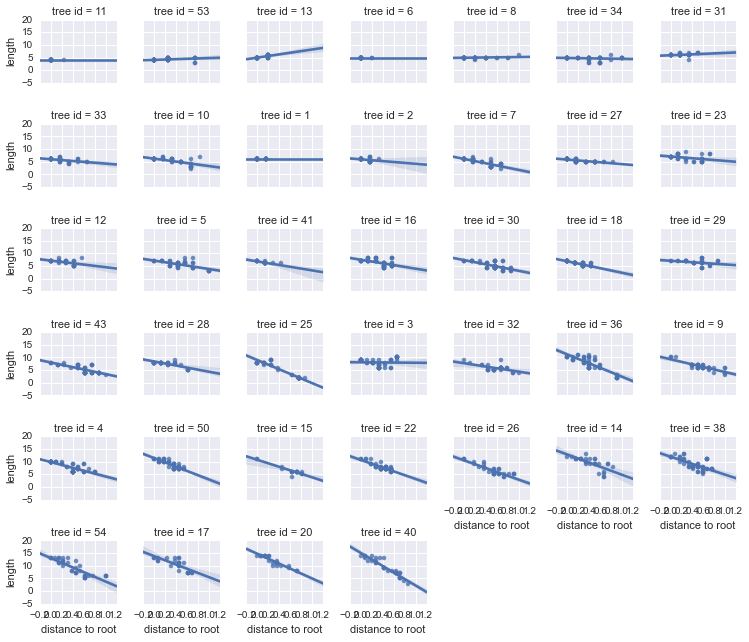

In [114]:
sb.lmplot(data=data[~data['tree id'].isin(too_much_content)],
          y='length', x='distance to root',
          col='tree id', col_wrap=7, size=1.5,
          col_order=root_order[~root_order['tree id'].isin(too_much_content)]['tree id']);

**This quantifies how much a sentence is transformed by elision vs. by replacement. A steeper slope means more elision, a flatter slope means more replacement (i.e. sentences are quite different from root without being any shorter).**

Finally, a **fourth look** where axes are not shared between plots (so we have a closeup to see how good the fit is)

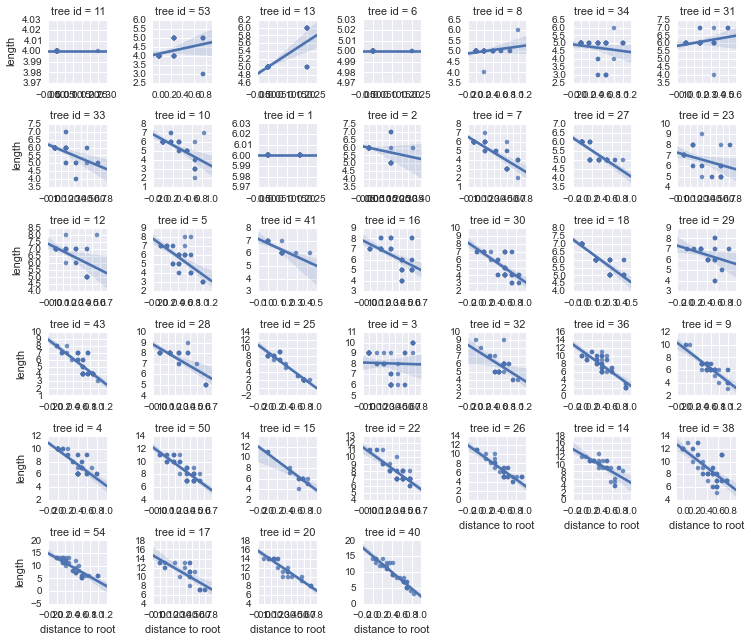

In [117]:
sb.lmplot(data=data[~data['tree id'].isin(too_much_content)],
          y='length', x='distance to root', sharex=False, sharey=False,
          col='tree id', col_wrap=7, size=1.5,
          col_order=root_order[~root_order['tree id'].isin(too_much_content)]['tree id']);

#### 2.1.1 A few more details

Here are the root sentences for all trees, for a detailed look:

In [90]:
for tree in Tree.objects.experiment.all():
    print('Tree #{}'.format(tree.id))
    print('--------')
    print(tree.root.text)
    print()

Tree #1
--------
The young boy was suddenly hit by the little girl

Tree #2
--------
Don't forget to leave the door open when you leave the office

Tree #3
--------
Don't forget to leave the door open when you leave the office so that the cleaning person can come in

Tree #4
--------
Don't forget to leave the door open when you leave the office so that the people robbing us don't break the windows

Tree #5
--------
By the way, I can't come and fetch you, but it's only a dozen kilometers, you can hitch-hike down to the village

Tree #6
--------
Can you pay the rent a little earlier this month?

Tree #7
--------
They want to keep it all for themselves, and I don't blame them, but it ends up being a rich ghetto

Tree #8
--------
This crisis did not develop overnight and it will not be solved overnight

Tree #9
--------
Immediately after I become president I will confront this economic challenge head-on by taking all necessary steps

Tree #10
--------
We can't point the finger at any polit

As explained above, tree #13 has:

In [89]:
print("{} non-spam sentences".format(Tree.objects.get(id=13).sentences.ham.count()))

42 non-spam sentences


And here are their content words:

In [86]:
[s.content_words for s in Tree.objects.get(id=13).sentences.ham.all()]

[['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'world', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaura', 'human', 'walk', 'earth', 'time'],
 ['dinosor', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'world', 'time'],
 ['dinosaur', 'human', 'walk', 'world', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['din

### 2.2 Fixed points

### 2.3 Trajectories